Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

__NOTE__ to the user: In first use, this notebook cannot be run top to bottom. It assumes that you have a bunch of csv files that are created at different points in the notebook.

Thanks:
* https://jackmckew.dev/sentiment-analysis-text-cleaning-in-python-with-vader.html
* https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html


In [79]:
import pandas as pd
import numpy as np
import os.path
import re
import pickle 
from nlpUtils import aardvark as aa 
from sklearn.metrics import f1_score # auc if I get embeddings
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
# sns.set(font_scale=1.5)

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords as nltkStop
from nltk import ngrams

In [80]:
import importlib
importlib.reload(aa)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<module 'nlpUtils.aardvark' from 'c:\\Users\\rnocker\\Desktop\\python\\thesisAgain\\nlpUtils\\aardvark.py'>

# Setup
Assumes that you have completed vaderPrep

In [81]:
# Import the files that result from dataSplitBalance

unbal_x_train = pd.read_csv("dataBalSetsEcodes/unbal_x_train.csv", header=0, index_col=0)
unbal_x_val = pd.read_csv("dataBalSetsEcodes/unbal_x_val.csv", header=0, index_col=0)
unbal_y_train = pd.read_csv("dataBalancedSets/unbal_y_train.csv", header=0, index_col=0)
unbal_y_val = pd.read_csv("dataBalancedSets/unbal_y_val.csv", header=0, index_col=0)

# And the test dataset
x_test = pd.read_csv("dataBalSetsEcodes/x_test.csv", header=0, index_col=0)
y_test = pd.read_csv("dataBalancedSets/y_test_sent.csv", header=0, index_col=0)

# And some odds and ends
# tweets_clean  = pd.read_csv("dataBalSetsEcodes/tweets_clean.csv", header=0, index_col=0) 
# emoji_df_full = pd.read_csv("data/emoji_full_mod1.csv", header=0, index_col=0)
# all_unlabeled_tweets = pd.read_csv("archiveData/all_unlabeled_tweets_ecodes.csv", header=0, index_col=0)

print("Unbalanced:")
print("x-train:", unbal_x_train.shape, "x-val:", unbal_x_val.shape, "y-train:", unbal_y_train.shape, "y-val:", unbal_y_val.shape)
print("TEST DATA")
print("x-TEST:", x_test.shape, "y-TEST:", y_test.shape)
# emoji_df_full.head()


Unbalanced:
x-train: (823, 3) x-val: (206, 3) y-train: (823, 5) y-val: (206, 5)
TEST DATA
x-TEST: (182, 3) y-TEST: (182, 5)


# NOTES
* the tweet_clean is the full, unsplit set - NOT for model development, only for finding emojis.
* the unbalanced, and testing sets can be used for VADER model development


# Alternate Term Check

In [82]:
# my_count = 0
# for id, text in zip(check_tweets.id_stable, check_tweets["ContentClean"]):
#     if "🔜" in text.lower():  #osamabin: 6; binladen: 11; ben laden: 1
#         print(id, ":", text)
#         my_count += 1
# my_count
# # Orig: left behind: 3992 instances in master_tweets

# Summary
We have several data sets, using different balancing techinques. In the data, the emoji have been replaced with text codes.We ran the base model, unmodified, on the TEST data and reported these results to set a baseline for VADER: 
* VADER-base prediction F-score, TEST, macro average: 0.571
* VADER-base prediction F-score, VAL, macro average: 0.511

Now we want to see if we can beat that with a modified model. 

We will only be using the unbalanced datasets (train, val, test), as VADER does not learn directly from the data, it is not affeced by imbalance. Fine-tuning the model is done manually: looking at the TRAIN data, evaluating what updates might be helpful, and validating those changes on the VAL data. The final model will be run again on the TEST data and results reported. 

# Next
First, we want to see if we can improve emoji handling. 
1. Get the VADER-base score on the VAL data for comparison
2. Update the lexicon to recognize the text codes and corresponding values that we set
3. run the Bert model again on the VALIDATION data


VADER-base, VAL prediction F-score, macro average: 0.511

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       125
           1       0.53      0.42      0.47        43
           2       0.30      0.74      0.42        38

    accuracy                           0.54       206
   macro avg       0.55      0.56      0.51       206
weighted avg       0.67      0.54      0.56       206

Confusion matrix:
 [[65 11 49]
 [ 8 18 17]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 68  13]
  [ 60  65]]

 [[147  16]
  [ 25  18]]

 [[102  66]
  [ 10  28]]]


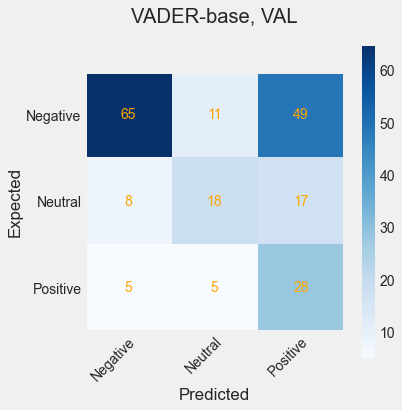

             count      mean       std     min     25%     50%       75%  \
y_true_test                                                                
0            125.0 -0.139031  0.544927 -0.9313 -0.6486 -0.1779  0.296000   
1             43.0  0.103428  0.440311 -0.8910  0.0000  0.0000  0.401650   
2             38.0  0.347795  0.381910 -0.6486  0.0320  0.3818  0.638175   

                max  
y_true_test          
0            0.8957  
1            0.8934  
2            0.9217  


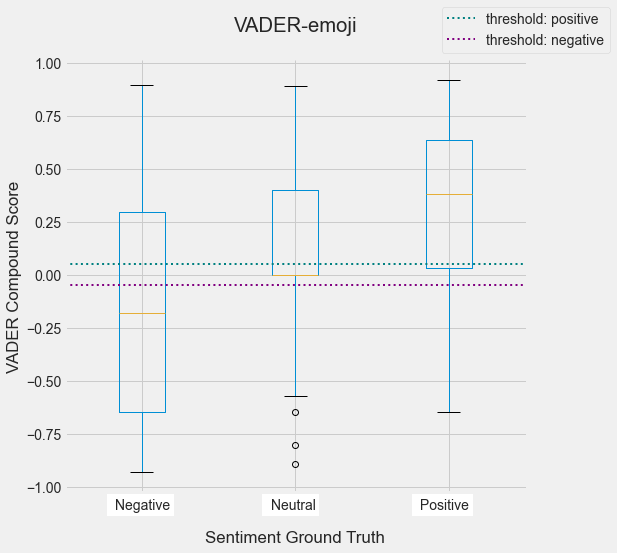

In [83]:
# If you have run the other model, reload aardvark before running this again to reset the sid
# importlib.reload(aa)

## Start by getting the VADER-base results on the VAL data, for comparison.
sid = SentimentIntensityAnalyzer() 

# Get the VADER compound score for the VAL data as a list
x_compound_VADERemoji = list(unbal_x_val["ContentClean"].apply(aa.vader_sent_compound))

# Get the VADERemoji prediction
y_pred_VADERemoji = unbal_x_val["ContentClean"].apply(aa.vader_pred)  #tweet, pos_cut = 0.05, neg_cut = -0.05

# Get the ground truth as a list
y_true_test = list(unbal_y_val["y_sent"])

# Get the prediction list
y_pred_VADERemoji = list(y_pred_VADERemoji)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-base, VAL", y_true=y_true_test, y_pred=y_pred_VADERemoji, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-base, VAL", y_true=y_true_test, y_pred=y_pred_VADERemoji, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['x_compound_VADERemoji'] = x_compound_VADERemoji
vaderEmoji_df['y_pred_VADERemoji'] = y_pred_VADERemoji
vaderEmoji_df['y_true_test'] = y_true_test
print(vaderEmoji_df.groupby('y_true_test')['x_compound_VADERemoji'].describe())
aa.boxplot_results(model_name="VADER-emoji", df=vaderEmoji_df, score_col='x_compound_VADERemoji', y_true_col="y_true_test", pos_threshold=0.05, neg_threshold=-0.05)

In [84]:
# # Load the sid and update it.
# sid = SentimentIntensityAnalyzer()

# a_file = open("data/change_lex.pkl", "rb")
# change_lex = pickle.load(a_file)
# a_file.close()

# sid.lexicon.update(change_lex)

# #Make sure we are using the updated lexicon; should output: 0.1891, 0.746
# # Note that the aa. functions don't use the updated lexicon!!!
# print(sid.polarity_scores("red_heart_e")["compound"])
# print(change_lex['red_heart_e'])

VADER-emoji prediction F-score, macro average: 0.487

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       125
           1       0.48      0.35      0.41        43
           2       0.29      0.74      0.41        38

    accuracy                           0.52       206
   macro avg       0.54      0.54      0.49       206
weighted avg       0.66      0.52      0.55       206

Confusion matrix:
 [[65 11 49]
 [ 8 15 20]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 68  13]
  [ 60  65]]

 [[147  16]
  [ 28  15]]

 [[ 99  69]
  [ 10  28]]]


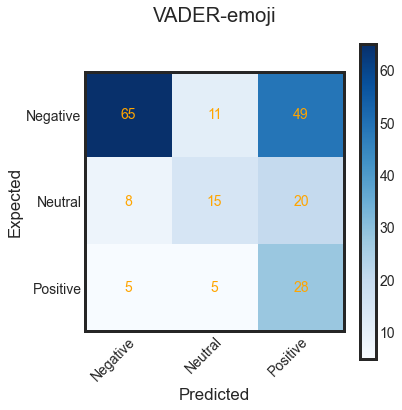

        count      mean       std     min     25%     50%       75%     max
y_true                                                                     
0       125.0 -0.139710  0.545797 -0.9313 -0.6486 -0.1779  0.296000  0.8957
1        43.0  0.132412  0.451151 -0.8910  0.0000  0.0000  0.411800  0.8934
2        38.0  0.348953  0.382194 -0.6486  0.0320  0.3818  0.638175  0.9253


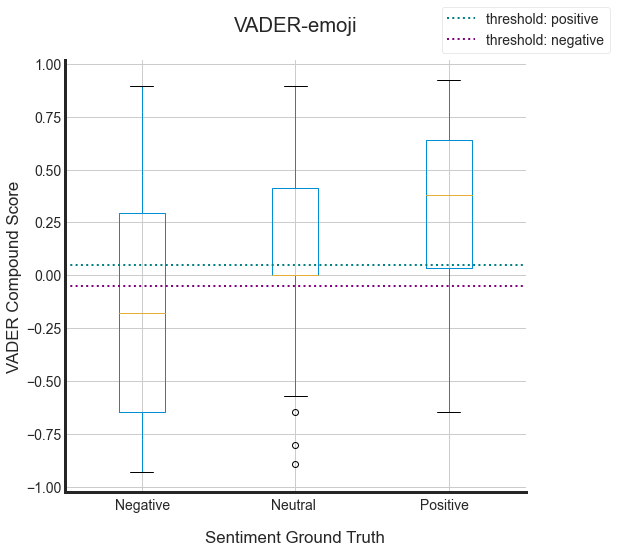

In [85]:
DATA = unbal_x_val
TRUE = unbal_y_val
MY_FN_C = aa.vader_sent_compound_update #uses "data/change_lex.pkl" 
Y_FN_P = aa.vader_pred_update

# STILL need to change the model name (in green) in 3 places

# Get the VADER compound score for the VAL data as a list
compound = list(DATA["ContentClean"].apply(MY_FN_C))

# Get the VADERemoji prediction
prediction = DATA["ContentClean"].apply(Y_FN_P)  #tweet, pos_cut = 0.05, neg_cut = -0.05

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the prediction list
prediction = list(prediction)

# Get the metrics
aa.print_model_metrics (model_name = "VADER-emoji", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-emoji", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-emoji", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=0.05, neg_threshold=-0.05)

In [86]:
# VADER-base, VAL prediction F-score, macro average: 0.511

#               precision    recall  f1-score   support

#            0       0.83      0.52      0.64       125
#            1       0.53      0.42      0.47        43
#            2       0.30      0.74      0.42        38

#     accuracy                           0.54       206
#    macro avg       0.55      0.56      0.51       206
# weighted avg       0.67      0.54      0.56       206


# VADER-emoji prediction F-score, macro average: 0.487

#               precision    recall  f1-score   support

#            0       0.83      0.52      0.64       125
#            1       0.48      0.35      0.41        43
#            2       0.29      0.74      0.41        38

#     accuracy                           0.52       206
#    macro avg       0.54      0.54      0.49       206
# weighted avg       0.66      0.52      0.55       206


So, it looks like this is making things a bit worse. 
* Not much change in precision, recall or f1 on the negative and positive classes
* Lower precision, recall or f1 on the neutral class

So there are emojis that the neutral tweets use that are pushing them further into one of the two camps. That makes sense. 

Theories about emoji that might cancel each other out:
* Extra theory: people use emoji sarcastically, which isn't being caught.
* Extra extra theory: but they also use it as a negator, which should help. And I *think* this should predominate.

Let's turn this off for now, and we can add it back in later.

In [87]:
importlib.reload(aa)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<module 'nlpUtils.aardvark' from 'c:\\Users\\rnocker\\Desktop\\python\\thesisAgain\\nlpUtils\\aardvark.py'>

# Word Clouds
__NOTE: There is a lot of preprocessing below that is ONLY used to make the wordclouds. VADER has it's own way of dealing with things like punctuation, capitalization, stopwords, tokenization, lemmatization. And we don't necessarilly want to mass with / override that without validating.__

In order to refine the dictionaries, I need to know what words and bigrams/trigrams are common in which datasets. So let's make word clouds.

First I need to create a single text per pos, neg, and neutral. Then I can feed them into wordcloud. I'll use the TRAIN dataset to generate them.

First just all the ContentClean

In [88]:
# SETUP

# changes to tokenizer and lemmatizer --> UPDATE in aardvark, too.
w_tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

### Full Data Wordcloud
from the full dataset, stopwords removed

In [89]:
# Establish the initial set of stopwords as a set that can be modified later
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [90]:
train_words = ' '.join(unbal_x_train["ContentClean"])
a = aa.lemmatize_text(train_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words = ' '.join(a)

dict_keys(['afghanistan', 'afghan', 'refugee', 'afghan refugee', 'taliban', 'country', 'people', 'asylum', 'united_states_e united_states_e', 'help', 'resettlement', 'wa', 'get', 'biden', 'new', 'uk', 'family', 'woman', 'many', 'need', 'resettle', 'translator', 'please', 'american', 'would', 'government', 'asylum seeker', 'like', 'year', 'life'])


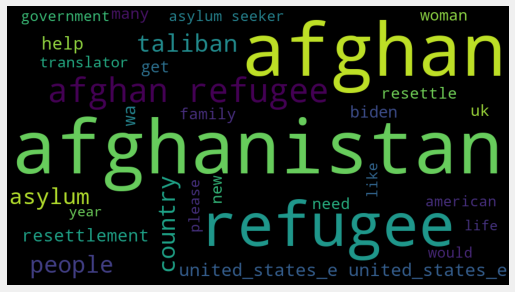

In [91]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words)
all_wc = wc.words_  # dictionary of the words used to make the cloud

print(all_wc.keys())
#print(WordCloud().process_text(lem_words))

plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


Need to break this down by label

In [92]:
print(list(unbal_x_train.columns))
print(list(unbal_y_train.columns))

['id_stable', 'Date', 'ContentClean']
['id_stable', 'label_sent', 'y_sent', 'label_stance', 'y_stance']


In [93]:
unbal_all_train = unbal_x_train.copy()
extracted_col = unbal_y_train["y_sent"].copy()
unbal_all_train = unbal_all_train.join(extracted_col)
unbal_all_train.head()

,id_stable,Date,ContentClean,y_sent
1191,5604,2022-03-30 21:49:53+00:00,"At the moment, that would be Mexican, Colombia...",0
52,56086,2021-10-11 06:48:52+00:00,Where went the promise of Afghan citizens rese...,0
816,39955,2021-11-26 22:09:37+00:00,What explanation does the government have for ...,0
481,44695,2021-11-12 12:37:18+00:00,"Iran Iran has provided shelter to 951,000 Afgh...",1
740,197583,2021-02-18 21:55:35+00:00,"Early 2016, a lefty grand-aunt of mine asked m...",0


In [94]:
# Break the data up per class
neg_list = []
neu_list = []
pos_list = []

for i, l in enumerate(unbal_all_train["y_sent"]):
    if l == 0:
        neg_list.append(unbal_all_train["ContentClean"].iloc[i])
    if l == 1:
        neu_list.append(unbal_all_train["ContentClean"].iloc[i])
    if l == 2:
        pos_list.append(unbal_all_train["ContentClean"].iloc[i])

# Turn the lists into long strings
neg_words = ' '.join(neg_list)
neu_words = ' '.join(neu_list)
pos_words = ' '.join(pos_list)

# Build the lists of lems
a = aa.lemmatize_text(neg_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words_neg = ' '.join(a)

b = aa.lemmatize_text(neu_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words_neu = ' '.join(b)

c = aa.lemmatize_text(pos_words)  # to change the tokenizer and lemmatizer from nltk, change in aardvark
lem_words_pos = ' '.join(c)

print(len(lem_words_neg))
print(len(lem_words_neu))
print(len(lem_words_pos))

99411
30165
30548


lem_words_neg


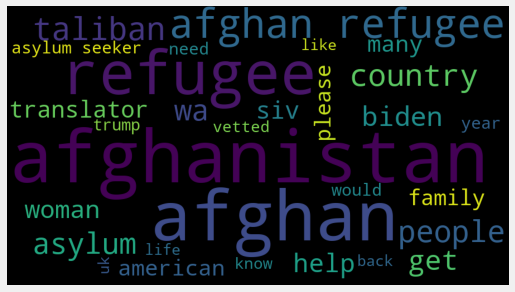

In [95]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neg)
neg_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neg")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


lem_words_neu


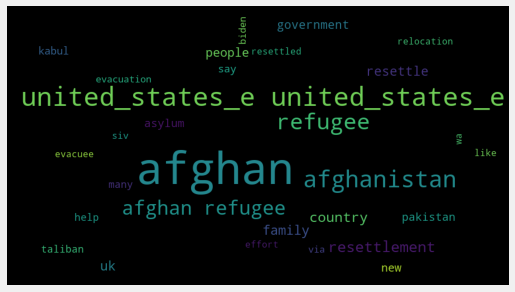

In [96]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neu)
neu_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neu")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


lem_words_pos


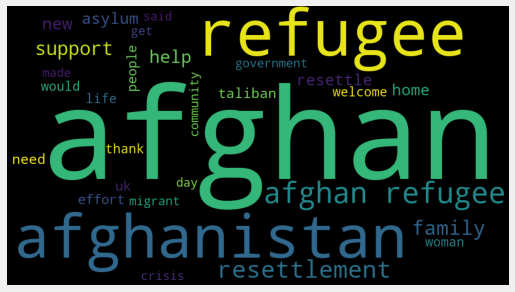

In [97]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_pos)
pos_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_pos")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()


In [98]:
print(neg_wc.keys())
#print(WordCloud().process_text(text))
print()
print(neu_wc.keys())
#print(WordCloud().process_text(text))
print()
print(pos_wc.keys())
#print(WordCloud().process_text(text))


dict_keys(['afghanistan', 'afghan', 'refugee', 'afghan refugee', 'taliban', 'country', 'people', 'wa', 'asylum', 'get', 'biden', 'help', 'woman', 'siv', 'translator', 'many', 'american', 'family', 'please', 'asylum seeker', 'need', 'would', 'year', 'trump', 'vetted', 'know', 'back', 'life', 'uk', 'like'])

dict_keys(['afghan', 'united_states_e united_states_e', 'afghanistan', 'refugee', 'afghan refugee', 'resettlement', 'country', 'family', 'uk', 'resettle', 'people', 'government', 'asylum', 'new', 'pakistan', 'kabul', 'say', 'taliban', 'many', 'help', 'biden', 'via', 'siv', 'evacuation', 'evacuee', 'resettled', 'relocation', 'wa', 'effort', 'like'])

dict_keys(['afghan', 'refugee', 'afghanistan', 'afghan refugee', 'resettlement', 'family', 'support', 'help', 'new', 'asylum', 'resettle', 'home', 'need', 'taliban', 'people', 'effort', 'uk', 'welcome', 'woman', 'thank', 'would', 'life', 'crisis', 'community', 'made', 'said', 'get', 'government', 'migrant', 'day'])


So we can see that some words are in the top spot on all three maps:
* afghanistan
* afghan
* refugee

Other
* "united_states_e" is an emoji and I think this was just a tweet of 120-some of this one emoji

So these can all be added to the stopwords.

### NOTE: 
for now, I will be adding to the stopwords and rerunning the next two code boxes, rather than repeating them.

### NOTE:
restarting from earlier stopwords to see if there is improvement.

In [99]:
# stopwords = nltkStop.words('english') + ["Afghan","Afghanistan", "refugee"]
# stopwords = nltkStop.words('english') + ["Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['made', 'said', 'day', 'already', 'via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
# stopwords = nltkStop.words('english') + ['new', 'one', 'wa', 'like', 'made', 'said', 'day', 'already', 'via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
stopwords = nltkStop.words('english') + ['could', 'dont', 'even', 'group', 'today', 'really', 'new', 'one', 'wa', 'like', 'made', 'said', 'day', 'already', 'via', 'time', 'must', 'know', 'back','family', 'help', 'ha', 'asylum', 'people', "Afghan","Afghanistan", "refugee", "united_states_e", "U", "S", "US", "K", "UK"]
#  

lem_words_neg


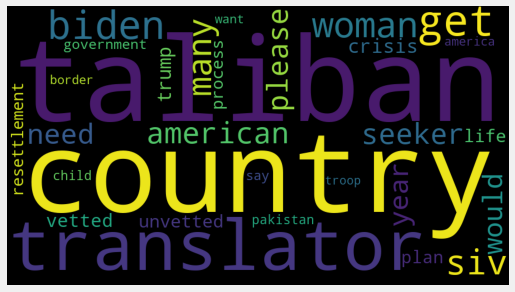

lem_words_neu


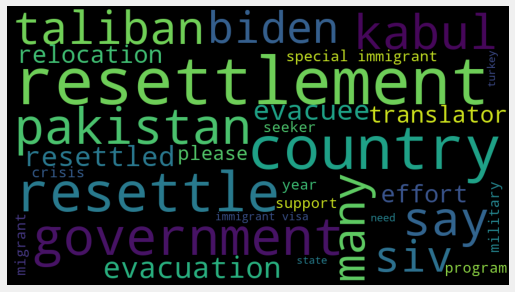

lem_words_pos


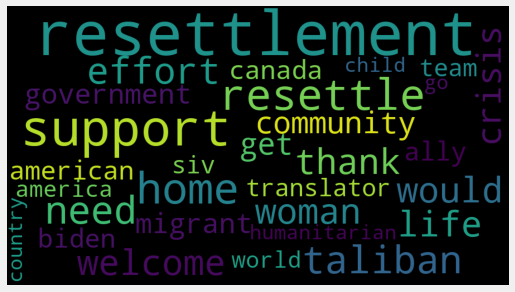

dict_keys(['taliban', 'country', 'translator', 'get', 'biden', 'woman', 'siv', 'many', 'american', 'seeker', 'please', 'need', 'would', 'year', 'crisis', 'trump', 'vetted', 'life', 'unvetted', 'plan', 'process', 'resettlement', 'government', 'say', 'child', 'pakistan', 'want', 'america', 'border', 'troop'])

dict_keys(['resettlement', 'country', 'resettle', 'government', 'pakistan', 'kabul', 'say', 'taliban', 'many', 'biden', 'siv', 'evacuation', 'evacuee', 'resettled', 'relocation', 'effort', 'translator', 'please', 'special immigrant', 'year', 'seeker', 'crisis', 'program', 'support', 'military', 'migrant', 'immigrant visa', 'state', 'turkey', 'need'])

dict_keys(['resettlement', 'support', 'resettle', 'home', 'need', 'taliban', 'effort', 'welcome', 'woman', 'thank', 'would', 'life', 'crisis', 'community', 'get', 'government', 'migrant', 'american', 'ally', 'canada', 'biden', 'translator', 'siv', 'team', 'world', 'america', 'humanitarian', 'child', 'go', 'country'])


In [100]:
wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neg)
neg_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neg")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_neu)
neu_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_neu")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

wc = WordCloud(stopwords=stopwords, width=900, height=500, max_words=30).generate(lem_words_pos)
pos_wc = wc.words_  # dictionary of the words used to make the cloud

print("lem_words_pos")
plt.figure(figsize=(8,6))
plt.imshow(wc)
plt.axis("off")
plt.show()

print(neg_wc.keys())
#print(WordCloud().process_text(text))
print()
print(neu_wc.keys())
#print(WordCloud().process_text(text))
print()
print(pos_wc.keys())
#print(WordCloud().process_text(text))


In [101]:
negs, neuts, poss = list(neg_wc.keys()), list(neu_wc.keys()), list(pos_wc.keys())
neg_alone, neu_alone, pos_alone, joint, all_in, neu_neg_sep, neu_pos_sep = [], [], [], [], [], [], []

# Find words in just one class (one list) or in two or more (separate list)
for word in negs:
    if (word not in neuts) and (word not in poss):
        neg_alone.append(word)
    else: joint.append(word)
for word in neuts:
    if (word not in negs) and (word not in poss):
        neu_alone.append(word)
    else: joint.append(word)
for word in poss:
    if (word not in negs) and (word not in neuts):
        pos_alone.append(word)
    else: joint.append(word)

# find words in all three classes
for word in poss:
    if (word in negs) and (word in neuts):
        all_in.append(word)

# find words that are in both neg and neu, but with a wide discrepancy in weighted frequency (0.5 or greater)
for word in neuts:
    if word in negs:
        if (neu_wc[word] - neg_wc[word] > 0.5) or (neu_wc[word] - neg_wc[word] < -0.5):
            neu_neg_sep.append(word)

# find words that are in both neg and neu, but with a wide discrepancy in weighted frequency (0.5 or greater)
for word in neuts:
    if word in poss:
        if (neu_wc[word] - pos_wc[word] > 0.5) or (neu_wc[word] - pos_wc[word] < -0.5):
            neu_pos_sep.append(word)

print("all:", all_in)
print("sep: neg v neu:", neu_neg_sep)
print("sep: pos v neu:", neu_pos_sep)
print()
print("joint:", joint)
print()
print("neg:", neg_alone)
print("neu:",neu_alone)
print("pos:",pos_alone)


all: ['resettlement', 'need', 'taliban', 'crisis', 'government', 'biden', 'translator', 'siv', 'country']
sep: neg v neu: ['resettlement', 'taliban']
sep: pos v neu: ['country']

joint: ['taliban', 'country', 'translator', 'get', 'biden', 'woman', 'siv', 'many', 'american', 'seeker', 'please', 'need', 'would', 'year', 'crisis', 'life', 'resettlement', 'government', 'say', 'child', 'pakistan', 'america', 'resettlement', 'country', 'resettle', 'government', 'pakistan', 'say', 'taliban', 'many', 'biden', 'siv', 'effort', 'translator', 'please', 'year', 'seeker', 'crisis', 'support', 'migrant', 'need', 'resettlement', 'support', 'resettle', 'need', 'taliban', 'effort', 'woman', 'would', 'life', 'crisis', 'get', 'government', 'migrant', 'american', 'biden', 'translator', 'siv', 'america', 'child', 'country']

neg: ['trump', 'vetted', 'unvetted', 'plan', 'process', 'want', 'border', 'troop']
neu: ['kabul', 'evacuation', 'evacuee', 'resettled', 'relocation', 'special immigrant', 'program', 'm

### First run
I think the "U" is from people doint "U S" or "U K" or such. That can go.
* U, S, K
* UK
* US

You can really start to see why it's hard to break out the neutral group: there are words that are in pos and not in neg, and vice versa; but the words in neutral tend to also be on one of the others.

### Next
Now you can start to see some things:
* all: ['family', 'help', 'ha', 'asylum', 'taliban', 'people']
  * Taliban is in all three, but it is so much more weighted in the neg, that I think I will leave it in. The rest to stopwords.
    * neg: 'taliban': 1.0
    * neu: 'taliban': 0.4782608695652174
    * pos: 'taliban': 0.36363636363636365
* Doubled: 'county' is in neg and neu, but not pos. Maybe give this a very slight negative score? It should help with distinguishing between pos and neg, but not with separating out the problematic neutral class. And neutral does seem to overlap more with neg than pos, so this is proabably not a good idea.
  
### Next
We begin to have a good list of per-class words:
* neg: ['trump', 'vetted', 'know', 'back', 'unvetted', 'plan', 'process'] + taliban
* neu: ['pakistan', 'kabul', 'via', 'evacuation', 'evacuee', 'resettled', 'relocation', 'time', 'must', 'special immigrant', 'program']
* pos: ['home', 'welcome', 'thank', 'community', 'made', 'said', 'migrant', 'day', 'ally', 'canada', 'already']

### Next
* "resettlement" looks like it is double with neutral and positive, maybe slightly postitive?

### way down
* country now makes it onto the neu/pos sep list, but you have to go too far for this to be useful.
  
## Update the lexicon
* neg: ['trump', 'vetted', 'unvetted', 'plan', 'process', 'border', 'troop'] + taliban
* neu: ['kabul', 'evacuation', 'evacuee', 'resettled', 'relocation', 'program']
* pos: ['home', 'welcome', 'thank', 'community', 'ally', 'team', 'humanitarian''] + resettlement

I will put all the neutrals at 0. For pos (and neg) I will start with .8 and work down in steps of .05 (neg, for neg)

In [102]:
# neg: ['trump', 'vetted', 'unvetted', 'plan', 'process', 'border', 'troop', 'taliban']
# neu: ['kabul', 'evacuation', 'evacuee', 'resettled', 'relocation', 'program']
# pos: ['home', 'welcome', 'thank', 'community', 'ally', 'team', 'humanitarian', 'resettlement']

# Load the sid and update it.
sid = SentimentIntensityAnalyzer()

change_lex_words = {
    'trump' : -.8, 'vetted' : -.75, 'unvetted' : -.7, 'plan' : -.65, 'process' : -.6, 'border' : -.5, 'troop' : -.4, 'taliban' : -.3,
    'kabul' : 0, 'evacuation' : 0, 'evacuee' : 0, 'resettled' : 0, 'relocation' : 0, 'program' : 0,
    'home' : .8, 'welcome' : .75, 'thank' : .7, 'community' : .65, 'ally' : .6, 'team' : .5, 'humanitarian' : .4, 'resettlement' : .3}

sid.lexicon.update(change_lex_words)

#Make sure we are using the updated lexicon; should output: 0.1891, 0.746
# Note that the aa. functions don't use the updated lexicon!!!
print(sid.polarity_scores("troop")["compound"])
print(change_lex_words['troop'])


-0.1027
-0.4


In [103]:
# Save the new lexicon with pickle: save change_lex_words as a dictionary that can be loaded in other files
a_file = open("data/change_lex_one.pkl", "wb")
pickle.dump(change_lex_words, a_file)
a_file.close()

VADER-lex1 prediction F-score, macro average: 0.489

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       125
           1       0.52      0.30      0.38        43
           2       0.29      0.74      0.42        38

    accuracy                           0.54       206
   macro avg       0.54      0.53      0.49       206
weighted avg       0.66      0.54      0.56       206

Confusion matrix:
 [[70  7 48]
 [11 13 19]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 65  16]
  [ 55  70]]

 [[151  12]
  [ 30  13]]

 [[101  67]
  [ 10  28]]]


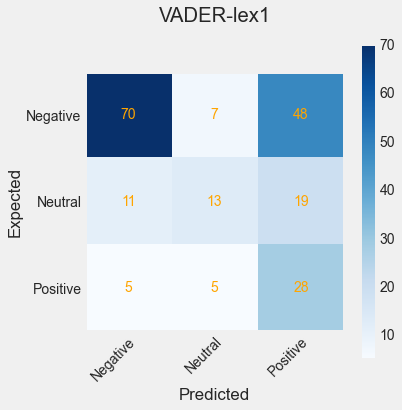

        count      mean       std     min     25%      50%       75%     max
y_true                                                                      
0       125.0 -0.166366  0.541955 -0.9313 -0.6705 -0.21410  0.273200  0.8957
1        43.0  0.087956  0.437114 -0.9022 -0.0386  0.00000  0.381800  0.9042
2        38.0  0.352595  0.391736 -0.6486  0.0641  0.40515  0.662875  0.9217


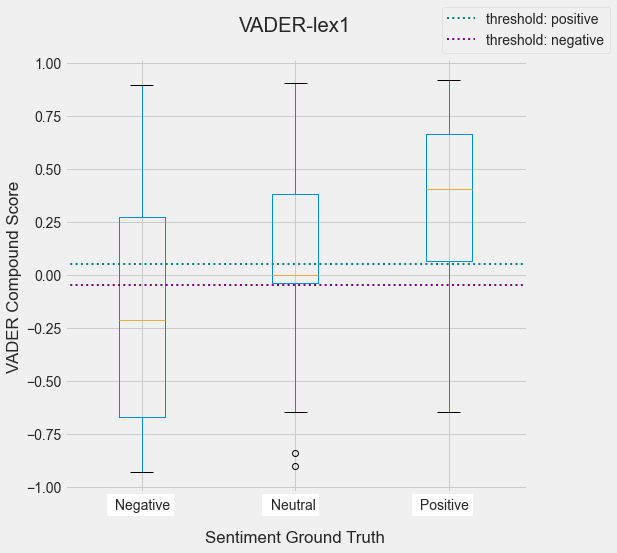

In [104]:
## SETUP
pickle_path="data/change_lex_one.pkl"
DATA = unbal_x_val
TRUE = unbal_y_val
MY_FN_C = 'aa.vader_sent_compound_update'
Y_FN_P = 'aa.vader_pred_update'
pos_cut = 0.05
neg_cut = -0.05
# STILL need to change the model name (in green) in 3 places


## ------------------------------------- ##
# Load the correct the lexicon
a_file = open(pickle_path, "rb")
change_lex = pickle.load(a_file)
a_file.close()
sid.lexicon.update(change_lex)

# Get the VADER compound score for the VAL data as a list
compound = []
for tweet in DATA["ContentClean"]:
    compound.append(sid.polarity_scores(tweet)["compound"])
compound = list(compound)

# Get the VADERemoji prediction
prediction = []
for i in compound:
    if i >= pos_cut:
        prediction.append(2)
    elif i <= neg_cut:
        prediction.append(0)
    else:
        prediction.append(1)
prediction = list(prediction)

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the metrics
aa.print_model_metrics (model_name = "VADER-lex1", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-lex1", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-lex1", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=0.05, neg_threshold=-0.05)

In [105]:
# VADER-base, VAL prediction F-score, macro average: 0.511

#               precision    recall  f1-score   support

#            0       0.83      0.52      0.64       125
#            1       0.53      0.42      0.47        43
#            2       0.30      0.74      0.42        38

#     accuracy                           0.54       206
#    macro avg       0.55      0.56      0.51       206
# weighted avg       0.67      0.54      0.56       206


# VADER-emoji prediction F-score, macro average: 0.487

#               precision    recall  f1-score   support

#            0       0.83      0.52      0.64       125
#            1       0.48      0.35      0.41        43
#            2       0.29      0.74      0.41        38

#     accuracy                           0.52       206
#    macro avg       0.54      0.54      0.49       206
# weighted avg       0.66      0.52      0.55       206


# VADER-lex1 prediction F-score, macro average: 0.489

#               precision    recall  f1-score   support

#            0       0.81      0.56      0.66       125
#            1       0.52      0.30      0.38        43
#            2       0.29      0.74      0.42        38

#     accuracy                           0.54       206
#    macro avg       0.54      0.53      0.49       206
# weighted avg       0.66      0.54      0.56       206

Still worse than no emoji at all, though slightly better.

One more go: combine the emoji and class word lexicons = lex2.

In [106]:
# Now for the emoji version
importlib.reload(aa)

# Load the sid and update it.
sid = SentimentIntensityAnalyzer()

a_file = open("data/change_lex.pkl", "rb")
change_lex_e = pickle.load(a_file)
a_file.close()

a_file = open("data/change_lex_one.pkl", "rb")
change_lex_one = pickle.load(a_file)
a_file.close()

sid.lexicon.update(change_lex_e)
sid.lexicon.update(change_lex_one)

#Make sure we are using the updated lexicon; should output: 0.1891, 0.746
# Note that the aa. functions don't use the updated lexicon!!!
print(sid.polarity_scores("red_heart_e")["compound"])
print(sid.polarity_scores("taliban")["compound"])

0.1891
-0.0772


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


VADER-lex2 prediction F-score, macro average: 0.489

              precision    recall  f1-score   support

           0       0.83      0.56      0.67       125
           1       0.52      0.30      0.38        43
           2       0.29      0.74      0.41        38

    accuracy                           0.54       206
   macro avg       0.55      0.53      0.49       206
weighted avg       0.67      0.54      0.56       206

Confusion matrix:
 [[70  7 48]
 [ 9 13 21]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 67  14]
  [ 55  70]]

 [[151  12]
  [ 30  13]]

 [[ 99  69]
  [ 10  28]]]


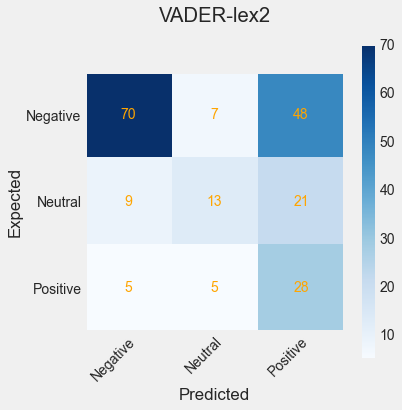

        count      mean       std     min     25%      50%       75%     max
y_true                                                                      
0       125.0 -0.166918  0.542670 -0.9313 -0.6705 -0.21410  0.273200  0.8957
1        43.0  0.117960  0.448040 -0.9022  0.0000  0.00000  0.407400  0.9042
2        38.0  0.353776  0.392029 -0.6486  0.0641  0.40515  0.662875  0.9217


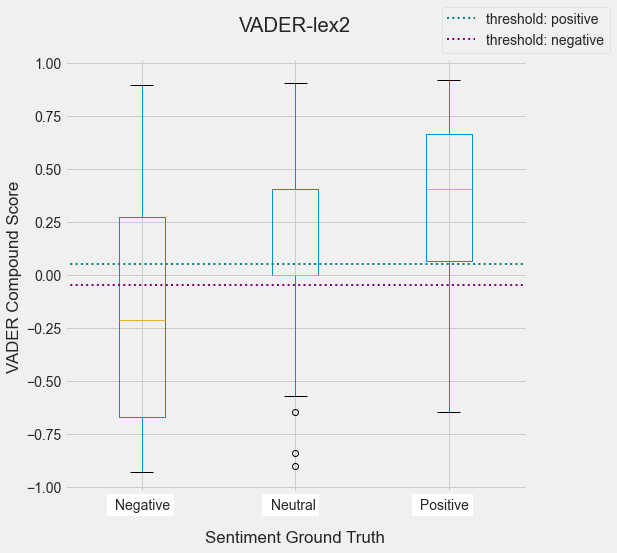

In [107]:
## SETUP
# pickle_path="data/change_lex_one.pkl"
DATA = unbal_x_val
TRUE = unbal_y_val
MY_FN_C = 'aa.vader_sent_compound_update'
Y_FN_P = 'aa.vader_pred_update'
pos_cut = 0.05
neg_cut = -0.05
# STILL need to change the model name (in green) in 3 places


## ------------------------------------- ##
# # Load the correct the lexicon - not needed this time
# a_file = open(pickle_path, "rb")
# change_lex = pickle.load(a_file)
# a_file.close()
# sid.lexicon.update(change_lex)

# Get the VADER compound score for the VAL data as a list
compound = []
for tweet in DATA["ContentClean"]:
    compound.append(sid.polarity_scores(tweet)["compound"])
compound = list(compound)

# Get the VADERemoji prediction
prediction = []
for i in compound:
    if i >= pos_cut:
        prediction.append(2)
    elif i <= neg_cut:
        prediction.append(0)
    else:
        prediction.append(1)
prediction = list(prediction)

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the metrics
aa.print_model_metrics (model_name = "VADER-lex2", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-lex2", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-lex2", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=0.05, neg_threshold=-0.05)

No change:

* VADER-base, VAL prediction F-score, macro average: 0.511
  * model ignores emoji codes
* VADER-emoji prediction F-score, macro average: 0.487
  * custom expanded emoji values in lexicon
* VADER-lex1 prediction F-score, macro average: 0.489
  * per-class sentiment lexicon values and and custom stopwords
* VADER-lex2 prediction F-score, macro average: 0.489
  * per-class sentiment lexicon values and and custom stopwords and custom expanded emoji values

Our best model is the one that ignores emoji. Sigh.

### NOTE
there are a few more things to try in archiveCode/vaderMoreMods.ipynb
* bi and trigrams for stopwords.

# Cutoff point as hyperparameter
Reload the best model (the one that ignores emoji) and play with cutoff points.

Looking at the bar and whisker graph, we can see that we want to look in the range from about 0.26 to -0.10. We will move by 0.05 steps, frist up, then down.
* Moving positive cutoff, holding negative at -0.05:
  * VADER_0.05 prediction F-score, macro average: 0.511
  * VADER_0.10 prediction F-score, macro average: 0.523
  * VADER_0.15 prediction F-score, macro average: 0.516
  * VADER_0.20 prediction F-score, macro average: 0.514
  * VADER_0.05 prediction F-score, macro average: 0.506
* Moving negative cutoff, holding positive at 0.10
  * VADER_-0.05 prediction F-score, macro average: 0.523
  * VADER_-0.10 prediction F-score, macro average: 0.519
  * VADER_-0.15 prediction F-score, macro average: 0.519

Selected cutoff points: 
* pos_cut = 0.10
* neg_cut = -0.05

VADER-threshold prediction F-score, macro average: 0.523

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       125
           1       0.51      0.47      0.49        43
           2       0.31      0.74      0.44        38

    accuracy                           0.55       206
   macro avg       0.55      0.57      0.52       206
weighted avg       0.67      0.55      0.57       206

Confusion matrix:
 [[65 14 46]
 [ 8 20 15]
 [ 5  5 28]]

Per-Class Confusion matrix:
 [[[ 68  13]
  [ 60  65]]

 [[144  19]
  [ 23  20]]

 [[107  61]
  [ 10  28]]]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


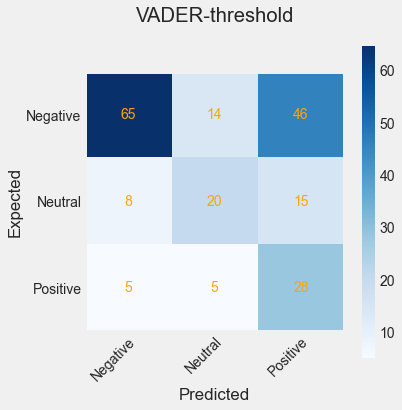

        count      mean       std     min     25%     50%       75%     max
y_true                                                                     
0       125.0 -0.139031  0.544927 -0.9313 -0.6486 -0.1779  0.296000  0.8957
1        43.0  0.103428  0.440311 -0.8910  0.0000  0.0000  0.401650  0.8934
2        38.0  0.347795  0.381910 -0.6486  0.0320  0.3818  0.638175  0.9217


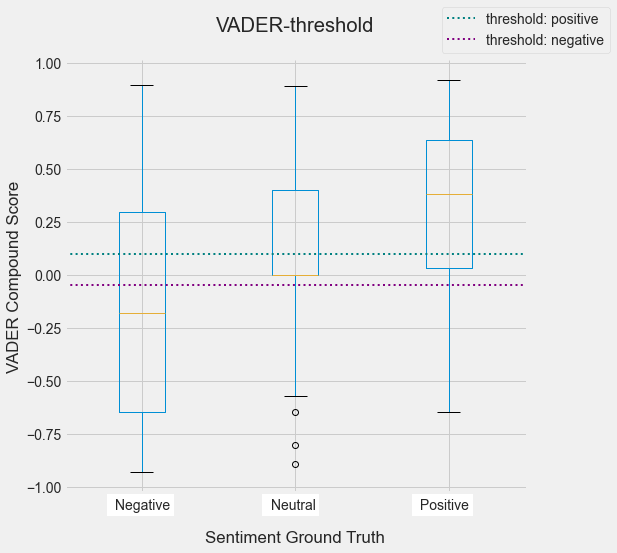

In [108]:
## SETUP
DATA = unbal_x_val
TRUE = unbal_y_val
pos_cut = 0.10
neg_cut = -0.05
# STILL need to change the model name (in green) in 3 places

# reset the sentiment analyzer
importlib.reload(aa)
sid = SentimentIntensityAnalyzer()

# Get the VADER compound score for the VAL data as a list
compound = []
for tweet in DATA["ContentClean"]:
    compound.append(sid.polarity_scores(tweet)["compound"])
compound = list(compound)

# Get the VADERemoji prediction
prediction = []
for i in compound:
    if i >= pos_cut:
        prediction.append(2)
    elif i <= neg_cut:
        prediction.append(0)
    else:
        prediction.append(1)
prediction = list(prediction)

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the metrics
aa.print_model_metrics (model_name = "VADER-threshold", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-threshold", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-threshold", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=pos_cut, neg_threshold=neg_cut)


# Now run the selected model on the test dataset.


VADER-threshold, test data prediction F-score, macro average: 0.588

              precision    recall  f1-score   support

           0       0.88      0.63      0.73       110
           1       0.52      0.45      0.48        38
           2       0.41      0.85      0.55        34

    accuracy                           0.63       182
   macro avg       0.60      0.64      0.59       182
weighted avg       0.72      0.63      0.65       182

Confusion matrix:
 [[69 12 29]
 [ 8 17 13]
 [ 1  4 29]]

Per-Class Confusion matrix:
 [[[ 63   9]
  [ 41  69]]

 [[128  16]
  [ 21  17]]

 [[106  42]
  [  5  29]]]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rnocker\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


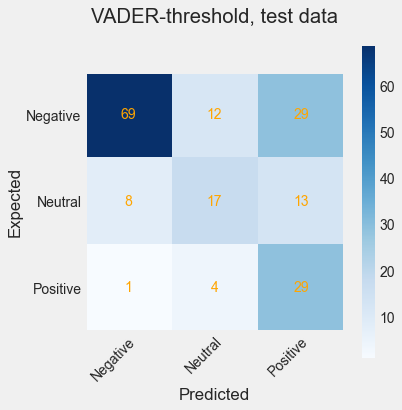

        count      mean       std     min      25%      50%       75%     max
y_true                                                                       
0       110.0 -0.226029  0.552149 -0.9559 -0.70030 -0.34000  0.225775  0.8919
1        38.0  0.065600  0.351207 -0.7469  0.00000  0.00000  0.306950  0.7579
2        34.0  0.491376  0.357922 -0.6908  0.32365  0.49365  0.833775  0.9246


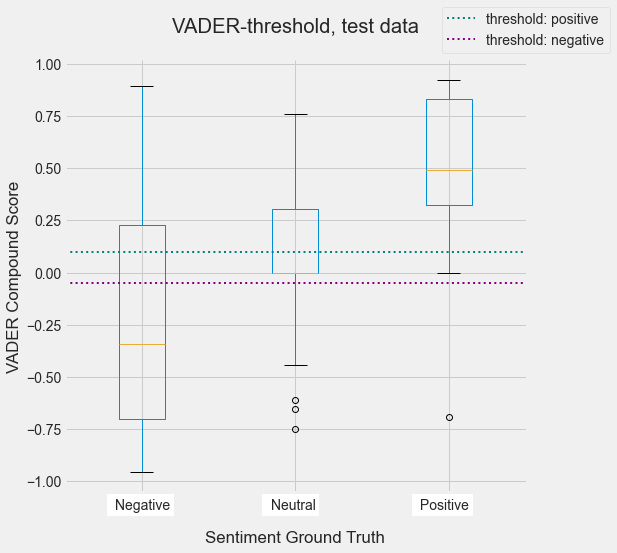

In [109]:
## SETUP
DATA = x_test
TRUE = y_test
pos_cut = 0.10
neg_cut = -0.05
# STILL need to change the model name (in green) in 3 places

# reset the sentiment analyzer
importlib.reload(aa)
sid = SentimentIntensityAnalyzer()

# Get the VADER compound score for the VAL data as a list
compound = []
for tweet in DATA["ContentClean"]:
    compound.append(sid.polarity_scores(tweet)["compound"])
compound = list(compound)

# Get the VADERemoji prediction
prediction = []
for i in compound:
    if i >= pos_cut:
        prediction.append(2)
    elif i <= neg_cut:
        prediction.append(0)
    else:
        prediction.append(1)
prediction = list(prediction)

# Get the ground truth as a list
y_true = list(TRUE["y_sent"])

# Get the metrics
aa.print_model_metrics (model_name = "VADER-threshold, test data", y_true=y_true, y_pred=prediction, labels=[0,1,2])
aa.print_conf_matrix (model_name = "VADER-threshold, test data", y_true=y_true, y_pred=prediction, labels=[0,1,2])

#NOTE: takes df as input with cols for compound score, prediction, and ground truth labels
# Create the df with compound score, prediction, and ground truth labels
vaderEmoji_df = pd.DataFrame()
vaderEmoji_df['compound'] = compound
vaderEmoji_df['prediction'] = prediction
vaderEmoji_df['y_true'] = y_true
print(vaderEmoji_df.groupby('y_true')['compound'].describe())
aa.boxplot_results(model_name="VADER-threshold, test data", df=vaderEmoji_df, score_col='compound', y_true_col="y_true", pos_threshold=pos_cut, neg_threshold=neg_cut)


# TO CONSIDER
When you look at the final plots, you really see that there is a lot of difference remaining between the validation and test splits. 
* More labeled data would be better. 
* FUTURE WORK: at what amount of data does this stabilize?
  

### esp. for BERT
* expand contractions
* remove links, URLs
* Replace emoji w standard text
* What to do with hashtags
* remove capitalization 
* What to do with punctuation: ! or ? should be useful for sentiment. Maybe " " for sarcasm?
* remove whitespaces
* Bertmoticon package, which is fine-tuned to the BERT model.
* remove stop words beyond the standard NLTK stop words
    * Create WordClouds to find prominant but useless words
    * Ex: days of the week and their abbreviations, month names, and the word “Twitter” 
* deal w negations
    * create a dictionary of negations so that negated words could be effectively handled
* tokenize 
* stemming (via PorterStemmer)
* REMEMBER:
    * Hashtags is filled with "No hashtags"
    * Location is filled with "English-speaking"

### --> Go to nlpBert/bert